In [7]:
import sys
from pathlib import Path

MODEL_DIR = Path("..").resolve()
print("MODEL_DIR:", MODEL_DIR, "exists:", MODEL_DIR.exists())

if str(MODEL_DIR) not in sys.path:
    sys.path.append(str(MODEL_DIR))

import cnn_dataset
import importlib
cnn_dataset = importlib.reload(cnn_dataset)

print("cnn_dataset file:", cnn_dataset.__file__)
from cnn_dataset import BubbleSegDataset


MODEL_DIR: C:\Users\thoma\OneDrive\ai_hardware\ai-bubbles\src\model exists: True
cnn_dataset file: C:\Users\thoma\OneDrive\ai_hardware\ai-bubbles\src\model\cnn_dataset.py


In [8]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import sys
from pathlib import Path
import numpy as np

# directory that contains cnn_dataset.py and small_unet.py
MODEL_DIR = Path("..").resolve()
print("MODEL_DIR:", MODEL_DIR, "exists:", MODEL_DIR.exists())

if str(MODEL_DIR) not in sys.path:
    sys.path.append(str(MODEL_DIR))

from cnn_dataset import BubbleSegDataset
from small_unet import SmallUNet

from cnn_dataset import BubbleSegDataset
from small_unet import SmallUNet

root = "../../../data/cnn"      # adjust path if needed
batch_size = 8
num_epochs = 10

train_ds = BubbleSegDataset(root, split="train")
val_ds = BubbleSegDataset(root, split="val")

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallUNet().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, msks in train_loader:
        imgs = imgs.to(device)
        msks = msks.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, msks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    train_loss = running_loss / len(train_ds)

    # quick val dice score
    model.eval()
    dices = []
    with torch.no_grad():
        for imgs, msks in val_loader:
            imgs = imgs.to(device)
            msks = msks.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            inter = (preds * msks).sum()
            union = preds.sum() + msks.sum()
            dice = (2 * inter + 1e-6) / (union + 1e-6)
            dices.append(dice.item())

    print(f"Epoch {epoch+1}/{num_epochs}  train_loss={train_loss:.4f}  val_dice={sum(dices)/len(dices):.3f}")

torch.save(model.state_dict(), "../../../data/cnn/small_unet_bubbles.pt")


MODEL_DIR: C:\Users\thoma\OneDrive\ai_hardware\ai-bubbles\src\model exists: True
Epoch 1/10  train_loss=0.1420  val_dice=0.831
Epoch 2/10  train_loss=0.0212  val_dice=0.865
Epoch 3/10  train_loss=0.0177  val_dice=0.885
Epoch 4/10  train_loss=0.0157  val_dice=0.908
Epoch 5/10  train_loss=0.0142  val_dice=0.915
Epoch 6/10  train_loss=0.0131  val_dice=0.906
Epoch 7/10  train_loss=0.0124  val_dice=0.926
Epoch 8/10  train_loss=0.0119  val_dice=0.928
Epoch 9/10  train_loss=0.0114  val_dice=0.934
Epoch 10/10  train_loss=0.0110  val_dice=0.933


RuntimeError: Parent directory ../../data/cnn does not exist.

In [9]:
from pathlib import Path

model_path = Path("../../../data/cnn/small_unet_bubbles.pt")
model_path.parent.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), model_path)
print("saved to", model_path)


saved to ..\..\..\data\cnn\small_unet_bubbles.pt


Loaded model from ..\..\..\data\cnn\small_unet_bubbles.pt


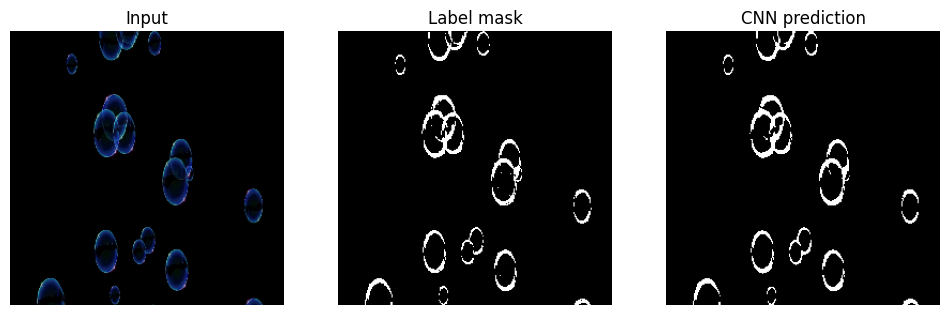

In [10]:
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
from small_unet import SmallUNet

# 1) Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallUNet().to(device)
ckpt_path = Path("../../../data/cnn/small_unet_bubbles.pt")
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state)
model.eval()
print("Loaded model from", ckpt_path)

# 2) Pick a sample image + mask
data_root = Path("../../../data/cnn")
img_path = sorted((data_root / "images").glob("*.png"))[0]
msk_path = data_root / "masks" / img_path.name

img = Image.open(img_path).convert("RGB")
msk = Image.open(msk_path).convert("L")

img_np = np.array(img)
msk_np = np.array(msk) / 255.0

# 3) Run inference
with torch.no_grad():
    x = torch.from_numpy(img_np).float().permute(2,0,1).unsqueeze(0) / 255.0  # [1,3,H,W]
    x = x.to(device)
    logits = model(x)
    probs = torch.sigmoid(logits)[0,0].cpu().numpy()
    pred = (probs > 0.5).astype(np.float32)

# 4) Plot GT vs prediction
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img_np)
plt.title("Input")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(msk_np, cmap="gray")
plt.title("Label mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="gray")
plt.title("CNN prediction")
plt.axis("off")

plt.show()
